In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os 
os.chdir('/content/gdrive/My Drive/Project_sem_8')

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
# break given text into sentences
text = 'My first birthday was great. My 2. was even better.The 22-year-old recently won ATP Challenger tournament.'
sentences = [i for i in nlp(text).sents]
sentences

[My first birthday was great.,
 My 2. was even better.,
 The 22-year-old recently won ATP Challenger tournament.]

In [ ]:
# get subject, object, pos for a particular sentence
doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22-year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [ ]:
import pandas as pd

In [ ]:
sentences_df = pd.read_csv("wiki_sentences_v2.csv")

In [ ]:
sentences_df['sentence'][3]

'the temple is set on fire.'

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
from tqdm import tqdm

In [ ]:
entity_pairs = []

for i in tqdm(sentences_df["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:46<00:00, 92.14it/s]


In [ ]:
entity_pairs[0:6]

[['connie', 'own'],
 ['later  woman', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['outside  cult', 'him'],
 ['it', 'religious  awakening']]

In [ ]:
from spacy.matcher import Matcher 
from spacy.tokens import Span

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in tqdm(sentences_df['sentence'])]

100%|██████████| 4318/4318 [00:45<00:00, 94.29it/s]


In [ ]:
relations[1]

'heard in'

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
kg_df

,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
...,...,...,...
4313,confidencial,negatively film,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,historical film 1946,was


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

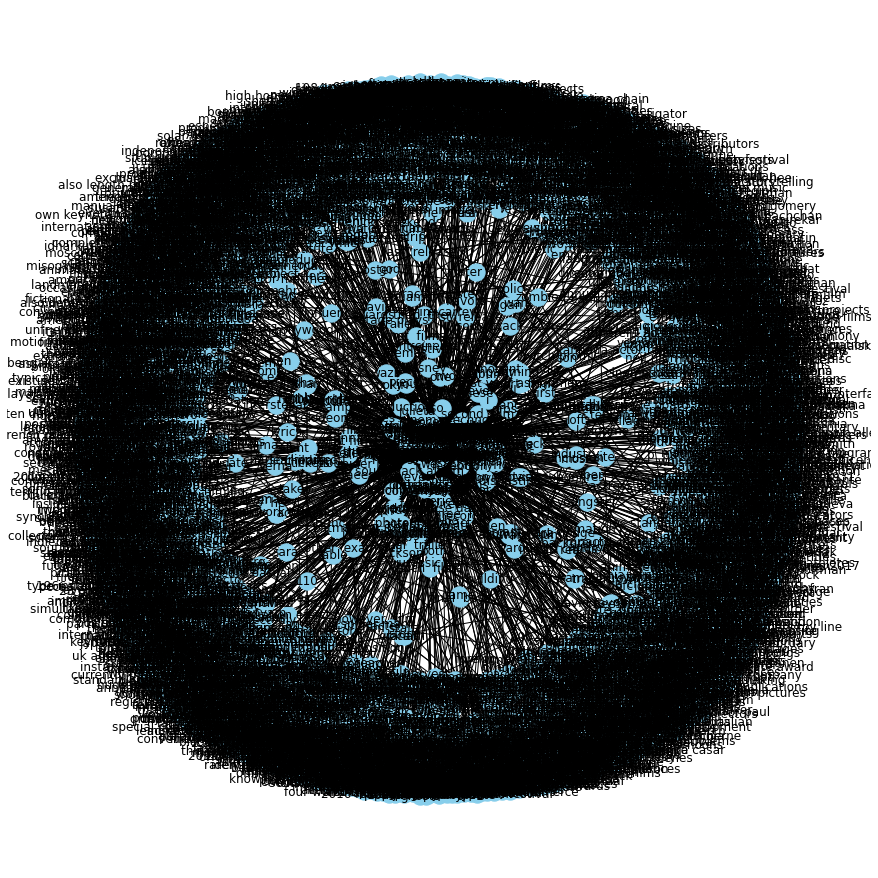

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

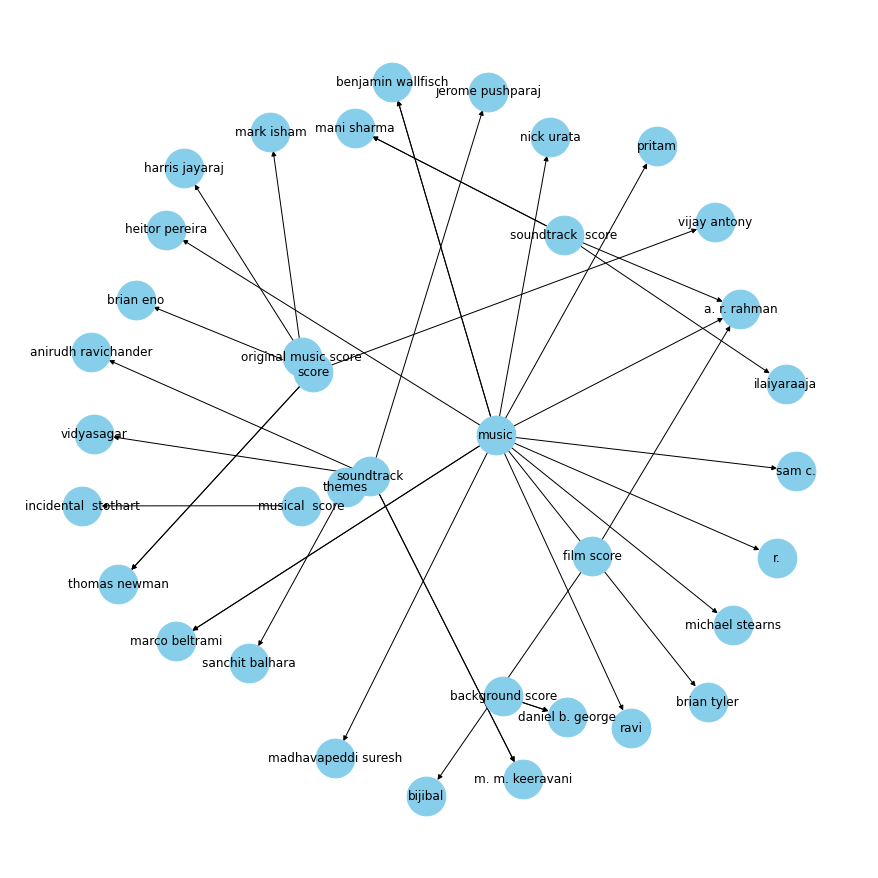

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

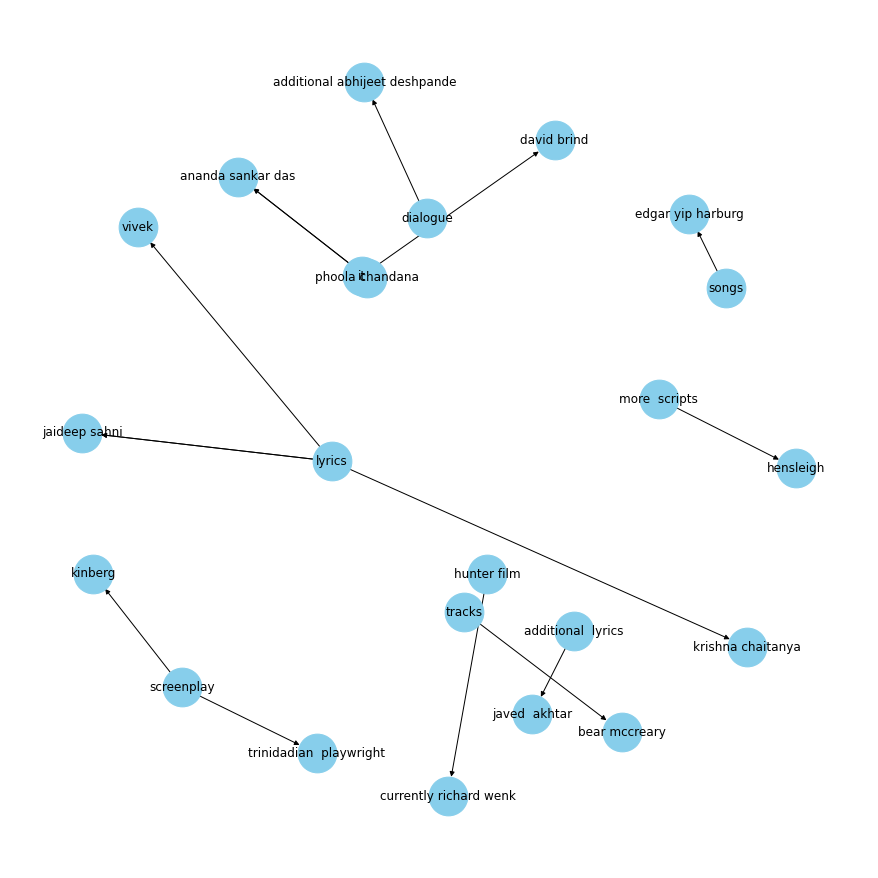

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

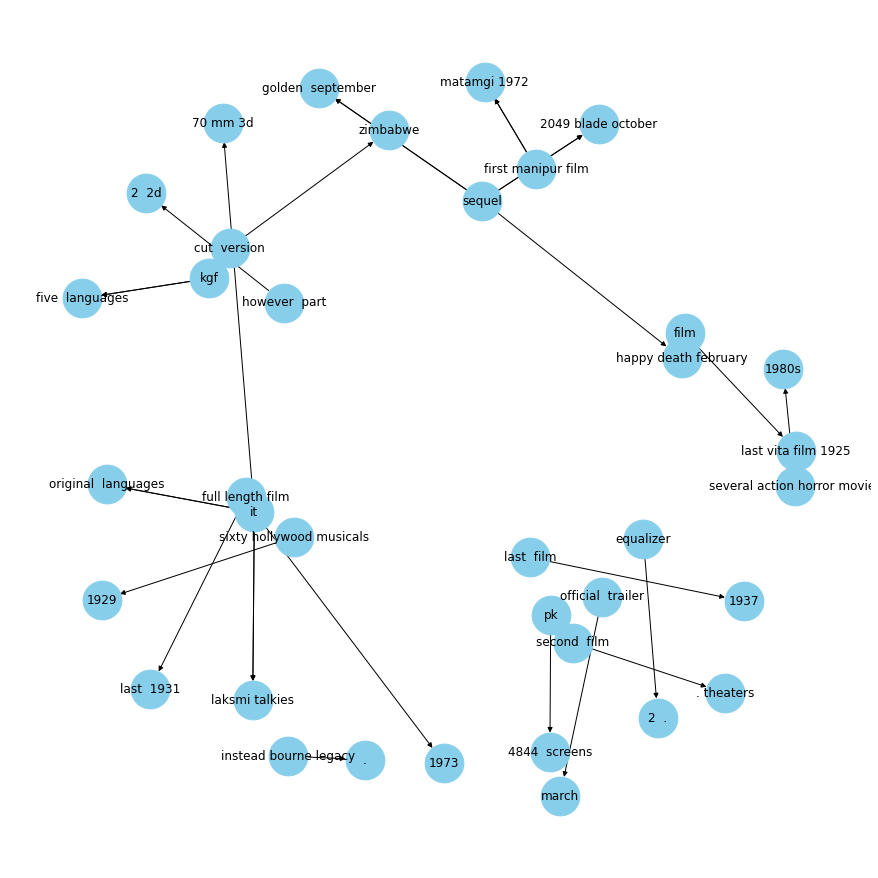

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
query = "what incident occured at temple"
print(get_entities(query))

['incident', 'temple']


In [ ]:
print(get_relation(query))

occured at


In [ ]:
if G.has_node("temple") or G.has_node("incident"):
  data = kg_df[(kg_df['source'] == "temple") | (kg_df['source'] == "incident")]
  idx_lst = data.index.tolist()



In [ ]:
sentences_df.iloc[idx_lst]

,sentence
3,the temple is set on fire.
